##### Libraries

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('scroll_down/main')
utils.load_extension('hide_input/main')
utils.load_extension('jupyter-js-widgets/extension')


<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport

from sklearn.linear_model import Lasso

from category_encoders.one_hot import OneHotEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error

from sklearn.tree import DecisionTreeRegressor,plot_tree
from catboost import CatBoostRegressor

import shap

from matplotlib import rcParams
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

rcParams['figure.figsize'] = 16,8

In [3]:
def plot_feature_importance(columnas,model_features,columns_ploted=10,model_name='Catboost'):
    '''
    This method is yet non-tested
    
    This function receives a set of columns feeded to a model, and the importance of each of feature.
    Returns a graphical visualization
    
    Call it fot catboost pipe example:
    plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,pipe_best_estimator.named_steps['cb'].get_feature_importance(),20)
    
    Call it for lasso pipe example:
    plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,np.array(pipe_best_estimator.named_steps['clf'].coef_.squeeze()),20)
    '''

    feature_importance = pd.Series(index = columnas, data = np.abs(model_features))
    n_selected_features = (feature_importance>0).sum()
    print('{0:d} features, reduction of {1:2.2f}%'.format(n_selected_features,(1-n_selected_features/len(feature_importance))*100))
    plt.figure()
    feature_importance.sort_values().tail(columns_ploted).plot(kind = 'bar', figsize = (18,6))
    plt.title('Feature Importance for {}'.format(model_name))
    plt.show()


In [4]:
file_path =  os.path.abspath(os.path.join('' ,"../..")) + '/Data/DHS-PROCESSED-CLEAN.csv'

In [5]:
df = pd.read_csv(file_path)

In [6]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [7]:
#profile.to_file("DHS_EDA_report.html")

## Modeling

In [8]:
cols_drop = [
    "DHSCLUST",
    "Wealth",
    "Wealth Index",
    "ADM1NAME",
    "LATNUM",
    "LONGNUM",
    "geometry",
    "DHSREGNA",
    "UN_Population_Density_2015",
]

scaler = MinMaxScaler()
df[["UN_Population_Density_2015"]] = scaler.fit_transform(
    df[["UN_Population_Density_2015"]]
)

X = df.drop(columns=cols_drop)
y = df[["Wealth Index"]]

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


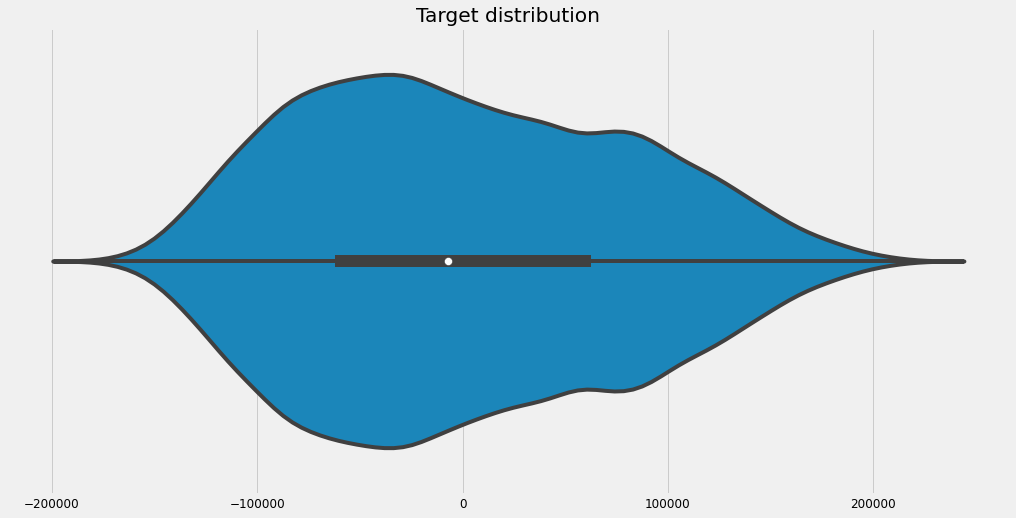

In [9]:
plt.figure()
plt.title('Target distribution')
sns.violinplot(y.values)
plt.show()

In [10]:
X.columns

Index(['Toilet Facility', 'Roof Material', 'Electricity', 'Cooking Fuel',
       'Drinking Water', 'URBAN_RURA', 'Population_Density'],
      dtype='object')

In [11]:
X_tr,X_te,y_tr,y_te = train_test_split(X,y)

### Regression

#### Linear OHE

In [12]:
model = Lasso()
enc = OneHotEncoder(use_cat_names=True)

In [13]:
pipe = Pipeline([('enc',enc), ('model',model)])

In [14]:
pipe.fit(X_tr,y_tr)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Objective did not converge. You might want to increase the number of iterations. Duality gap: 688851758778.7461, tolerance: 13450967706.337183


Pipeline(steps=[('enc',
                 OneHotEncoder(cols=['Toilet Facility', 'Roof Material',
                                     'Electricity', 'Cooking Fuel',
                                     'Drinking Water', 'URBAN_RURA',
                                     'Population_Density'],
                               use_cat_names=True)),
                ('model', Lasso())])

In [15]:
mean_absolute_error(pipe.predict(X_te),y_te)

27953.419852965326

40 features, reduction of 6.98%


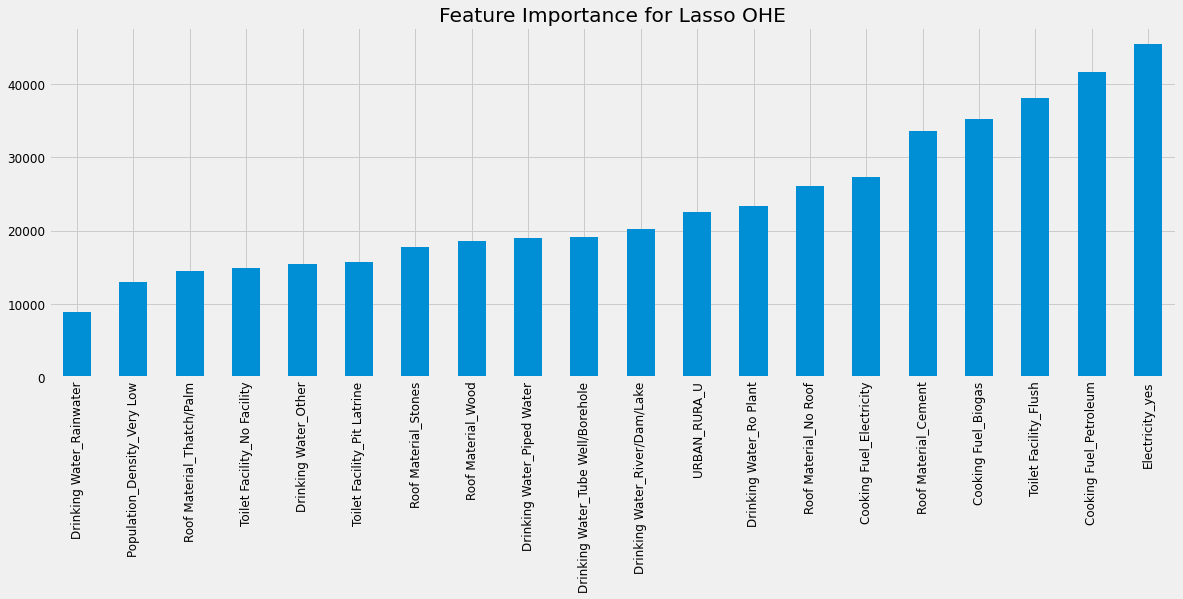

In [16]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    np.array(pipe.named_steps["model"].coef_.squeeze()),
    20,model_name='Lasso OHE'
)

#### Linear TE

In [17]:
model = Lasso()
enc = CatBoostEncoder()

pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

Pipeline(steps=[('enc',
                 CatBoostEncoder(cols=['Toilet Facility', 'Roof Material',
                                       'Electricity', 'Cooking Fuel',
                                       'Drinking Water', 'URBAN_RURA',
                                       'Population_Density'])),
                ('model', Lasso())])

In [18]:
mean_absolute_error(pipe.predict(X_te),y_te)

28784.628343260647

7 features, reduction of 0.00%


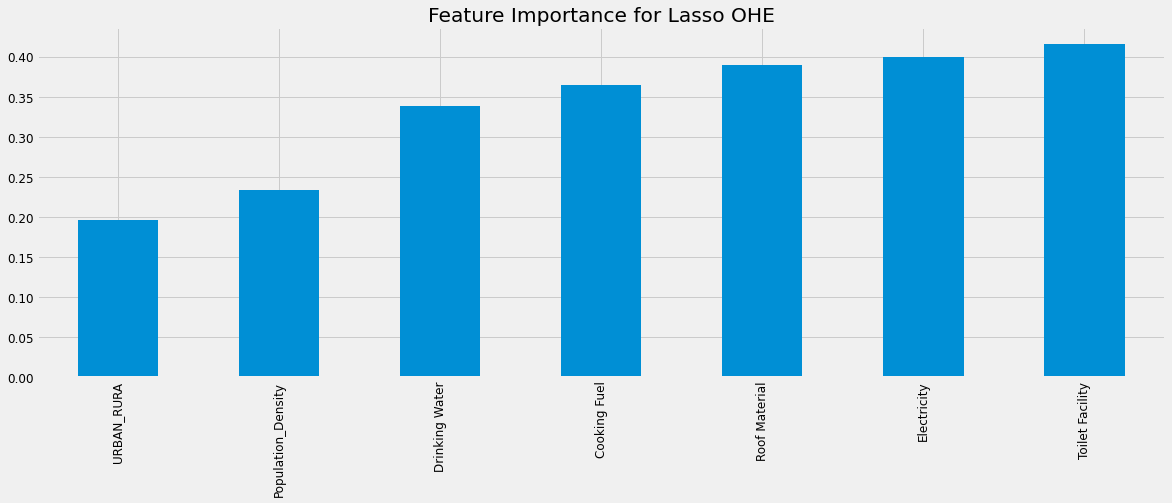

In [19]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    np.array(pipe.named_steps["model"].coef_.squeeze()),
    20,model_name='Lasso OHE'
)

#### Decision Tree TE

In [20]:
model = DecisionTreeRegressor(max_depth=5)
enc = CatBoostEncoder()

pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

Pipeline(steps=[('enc',
                 CatBoostEncoder(cols=['Toilet Facility', 'Roof Material',
                                       'Electricity', 'Cooking Fuel',
                                       'Drinking Water', 'URBAN_RURA',
                                       'Population_Density'])),
                ('model', DecisionTreeRegressor(max_depth=5))])

In [21]:
mean_absolute_error(pipe.predict(X_te),y_te)

28404.413362167186

In [22]:
pipe.named_steps["model"]

DecisionTreeRegressor(max_depth=5)

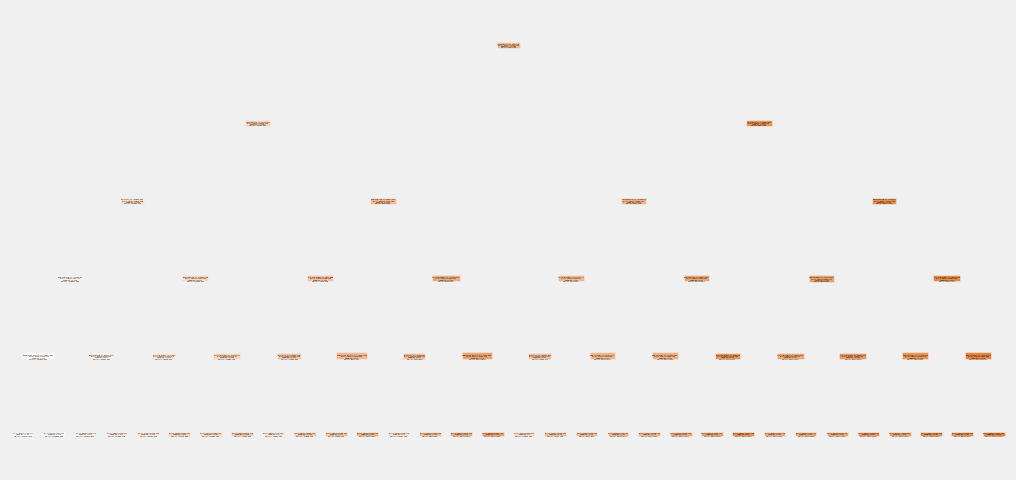

In [23]:
plt.figure()
plot_tree(
    pipe.named_steps["model"],
    max_depth=5,
    feature_names=X_tr.columns,
    filled=True,
)
plt.savefig('tree_te.svg',format='svg')
plt.show()

#### Decision Tree OHE

In [24]:
model = DecisionTreeRegressor(max_depth=8)
enc = OneHotEncoder()
pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Pipeline(steps=[('enc',
                 OneHotEncoder(cols=['Toilet Facility', 'Roof Material',
                                     'Electricity', 'Cooking Fuel',
                                     'Drinking Water', 'URBAN_RURA',
                                     'Population_Density'])),
                ('model', DecisionTreeRegressor(max_depth=8))])

In [25]:
mean_absolute_error(pipe.predict(X_te),y_te)

26621.487287800595

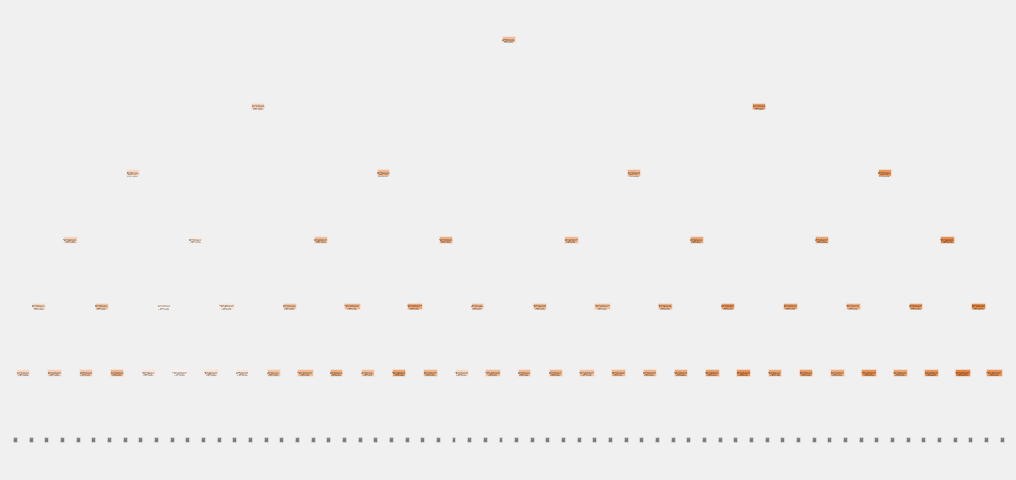

In [26]:
plt.figure()
plot_tree(
    pipe.named_steps["model"],
    max_depth=5,
    feature_names=pipe[:-1].transform(X_tr).columns,
    filled=True,
)
plt.savefig('tree_ohe.svg',format='svg')
plt.show()

#### Catboost TE

In [27]:
model = CatBoostRegressor(iterations=200,verbose=0)
enc = CatBoostEncoder()
pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

Pipeline(steps=[('enc',
                 CatBoostEncoder(cols=['Toilet Facility', 'Roof Material',
                                       'Electricity', 'Cooking Fuel',
                                       'Drinking Water', 'URBAN_RURA',
                                       'Population_Density'])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fda020d2a30>)])

In [28]:
mean_absolute_error(pipe.predict(X_te),y_te)

26327.559787384

7 features, reduction of 0.00%


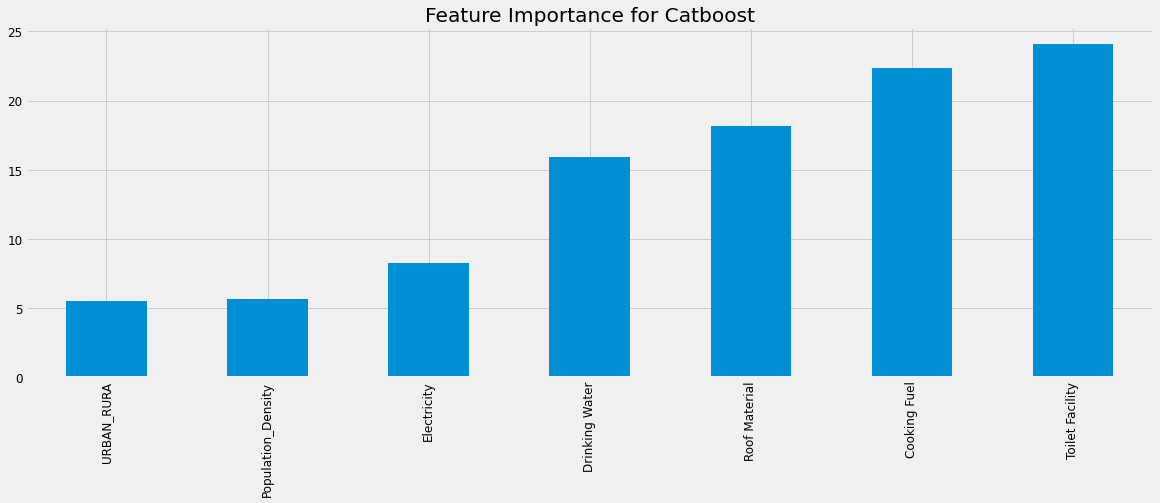

In [29]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    pipe.named_steps["model"].get_feature_importance(),
    20,
)

In [30]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(pipe.named_steps["model"])
shap_values = explainer.shap_values(pipe[:-1].transform(X_tr))

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
shap.summary_plot(shap_values, X_te, plot_type="bar")